In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from scipy.linalg import pascal
from scipy.stats import norm
import warnings
import scipy
warnings.filterwarnings("ignore")



$$\frac{\partial u}{\partial \tau} = \frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial u}{\partial x} \left(1 + \frac{2r}{\sigma^{2}}\right)$$
$$ h = {X \over M} $$
$$ tau = {\widetilde \Tau \over N} $$


$$ u_{m}^{n + 1} - u_{m}^{n} = {\tau \over h^{2}}  (u_{m - 1}^{n + 1} - 2u_{m}^{n + 1} + u_{m + 1}^{n + 1}) + {\tau \over h}(1 + D)(u_{m + 1}^{n + 1} - u_{m}^{n + 1})$$

Matrix coef:
$$ \alpha = 1 + {\tau \over h} \left({2 \over h} + 1 +  D \right) $$
$$ \beta = -{\tau \over h}\left({1 \over h} - 1 - D\right)$$
$$ \gamma = -{\tau \over h^{2}} $$

In [28]:
T, N = 1, 2 * 10 ** 2
S_1, S_2, K = 300, 400, 350
r, sigma= 0.1, 0.05
M = N
T_wave = (sigma ** 2) * T / 2
D = (2 * r) / (sigma ** 2)
X_1 = np.log(S_1 / K)
X_2 = np.log(S_2 / K)
X_arr = np.linspace(X_1, X_2, N)

tau = T_wave / N
h = abs(X_1 - X_2) / N
print('tau:', tau)
print('h:', h)
print()
U_shape = (N, N)
print('U_shape:', N * N)
U = np.zeros(U_shape)
print()
print(tau / (pow(h , 2) / 2))
print()
alpha = 1 + 2 * (tau / pow(h, 2)) + (tau / h) * (1 + D)
beta = - tau / pow(h , 2) - (tau / h) * (1 + D)
gamma = (-tau / pow(h, 2))
print('alpha:', alpha)
print('beta:', beta)
print('gamma:', gamma)

tau: 6.250000000000001e-06
h: 0.0014384103622589045

U_shape: 40000

6.0414948125848875

alpha: 7.393445836634086
beta: -3.372698430341642
gamma: -3.0207474062924438


In [3]:
# инициализация, граничные условия
D = (2 * r) / (sigma ** 2)

for m in range(len(X_arr)):
    if 1 - np.exp(-X_arr[m]) > 0:
        U[0][m] = 1 - np.exp(-X_arr[m])
    else:
        U[0][m] = 0

for n in range(N):
    U[n, -1] = 1 - np.exp(-D * tau * n - X_arr[-1])

In [4]:
def get_a_matrix(alpha, beta, gamma, N):
    a = np.zeros((N - 2, N - 2))
    for i in range(N - 2):
            for j in range(N - 2):
                if i == j:
                    a[i][j] = alpha
                if i == j + 1:
                    a[i][j] = gamma
                if i == j - 1:
                    a[i][j] = beta
    return a

In [5]:
def get_U(beta, gamma, layer_number, N, a_matrix):
    a = a_matrix

    b = np.zeros(N - 2)     # если размерность сетки N * N
    s = layer_number
    for j in range(len(b)):
        if j == 0:
            b[j] = U[s][j + 1] - gamma * U[s + 1][j]
        if  j == len(b) - 1:
            b[j] = U[s][j + 1] - beta * U[s + 1][j + 2]
        if (j > 0) and (j < len(b) - 1):
            b[j] = U[s][j + 1]


    n = len(b)
    x = np.zeros(len(b)) # обнуление вектора решений

    # Прямой ход
    v = np.zeros(n)
    u = np.zeros(n)
    # для первой 0-й строки
    v[0] = a[0][1] / (-a[0][0]) 
    u[0] = b[0] / a[0][0]
    for i in range(1, n - 1): # заполняем за исключением 1-й и (n-1)-й строк матрицы
        v[i] = a[i][i + 1] / (-a[i][i] - a[i][i - 1] * v[i - 1])
        u[i] = (a[i][i - 1] * u[i - 1] - b[i]) / (-a[i][i] - a[i][i - 1] * v[i - 1])
    # для последней (n-1)-й строки
    v[n - 1] = 0
    u[n - 1] = (a[n - 1][n - 2] * u[n - 2] - b[n - 1]) / (-a[n - 1][n - 1] - a[n - 1][n - 2] * v[n - 2])


    # Обратный ход
    if u[n - 1] > 0:
        x[n - 1] = u[n - 1]
    else:
        x[n - 1] = 0
    for i in range(n - 1, 0, -1):
        if v[i - 1] * x[i] + u[i - 1] > 0:
            x[i - 1] = v[i - 1] * x[i] + u[i - 1]
        else:
            x[i - 1] = 0
    return x

In [6]:
a = get_a_matrix(alpha, beta, gamma, N)
for s in range(N - 1):
    U[s + 1][1:-1] = get_U(beta, gamma, s, N, a)

In [7]:
pd.DataFrame(U)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.113541,0.114822,0.116101,0.117377,0.118652,0.119926,0.121197,0.122466,0.123734,0.125000
1,0.0,1.185982e-26,2.599846e-26,4.637019e-26,7.836475e-26,1.302556e-25,2.153521e-25,3.554202e-25,5.862532e-25,9.668213e-25,...,0.113986,0.115266,0.116544,0.117820,0.119095,0.120367,0.121638,0.122906,0.124173,0.125437
2,0.0,3.516422e-25,7.673344e-25,1.359453e-24,2.279109e-24,3.755314e-24,6.152297e-24,1.005944e-23,1.643609e-23,2.684678e-23,...,0.114431,0.115710,0.116987,0.118263,0.119536,0.120808,0.122078,0.123345,0.124611,0.125875
3,0.0,5.309955e-24,1.153593e-23,2.030508e-23,3.377650e-23,5.518106e-23,8.959965e-23,1.451686e-22,2.349984e-22,3.802575e-22,...,0.114875,0.116154,0.117430,0.118705,0.119978,0.121249,0.122517,0.123784,0.125049,0.126312
4,0.0,5.444334e-23,1.177733e-22,2.059939e-22,3.400648e-22,5.509590e-22,8.868432e-22,1.424058e-21,2.284403e-21,3.662612e-21,...,0.115319,0.116597,0.117873,0.119147,0.120419,0.121689,0.122957,0.124223,0.125487,0.126748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,7.745181e-04,1.473475e-03,2.109488e-03,2.693404e-03,3.234546e-03,3.740927e-03,4.219439e-03,4.676005e-03,5.115722e-03,...,0.195932,0.197089,0.198245,0.199398,0.200550,0.201701,0.202849,0.203996,0.205142,0.206285
196,0.0,7.924961e-04,1.507623e-03,2.158250e-03,2.755440e-03,3.308705e-03,3.826223e-03,4.315026e-03,4.781163e-03,5.229836e-03,...,0.196334,0.197491,0.198645,0.199798,0.200950,0.202100,0.203248,0.204394,0.205539,0.206682
197,0.0,8.107056e-04,1.542211e-03,2.207636e-03,2.818265e-03,3.383801e-03,3.912588e-03,4.411801e-03,4.887614e-03,5.345337e-03,...,0.196736,0.197892,0.199046,0.200198,0.201349,0.202499,0.203646,0.204792,0.205936,0.207079
198,0.0,8.291460e-04,1.577236e-03,2.257645e-03,2.881879e-03,3.459834e-03,4.000021e-03,4.509762e-03,4.995355e-03,5.462220e-03,...,0.197137,0.198293,0.199446,0.200598,0.201749,0.202897,0.204044,0.205189,0.206333,0.207475


In [8]:
V = U * np.linspace(S_1, S_2, N)
V_numerical = pd.DataFrame(V)
ans_numerical = V_numerical.sum(axis=0) / V_numerical.shape[0]
ans_numerical = ans_numerical

In [9]:
def d_plus(s, sigma, T, t, r, strike): 
    return ((math.log(s / strike)) + (T - t) * (r + (sigma ** 2) / 2)) / (sigma * math.sqrt(T - t))

In [10]:
def d_minus(s, sigma, T, t, r, strike):
    return ((math.log(s / strike)) + (T - t) * (r - (sigma ** 2) / 2)) / (sigma * math.sqrt(T - t))

In [11]:
def price_call_option(s, sigma, T, t, r, strike):
    I_plus = norm.cdf(d_plus(s, sigma, T, t, r, strike))
    I_minus = norm.cdf(d_minus(s, sigma, T, t, r, strike))
    ans = s * I_plus - strike * math.exp(-1 * r * (T - t)) * I_minus
    return ans

In [12]:
S_arr = K * np.exp(X_arr)
t_arr = T - (2 / (sigma ** 2)) * np.linspace(0, T_wave, N)

In [13]:
exact = np.zeros((U_shape))
for i in tqdm(range(len(t_arr))):
    for j in range(len(S_arr)):
        exact[i][j] = price_call_option(S_arr[j], sigma, T, t_arr[i], r, K)


100%|██████████| 200/200 [00:09<00:00, 20.74it/s]


In [14]:
V_exact = pd.DataFrame(exact)
ans_exact = V_exact.sum(axis=0) / V_exact.shape[0]
ans_exact

0       0.153985
1       0.164988
2       0.176676
3       0.189083
4       0.202246
         ...    
195    64.623224
196    65.198561
197    65.774730
198    66.351732
199    66.929570
Length: 200, dtype: float64

In [15]:
V_numerical

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,44.902983,45.467120,46.031811,46.597053,47.162846,47.729187,48.296074,48.863507,49.431483,50.000000
1,0.0,3.563906e-24,7.825666e-24,1.398096e-23,2.366694e-23,3.940396e-23,6.525494e-23,1.078763e-22,1.782328e-22,2.944190e-22,...,45.078915,45.643016,46.207667,46.772865,47.338603,47.904875,48.471670,49.038969,49.606746,50.174956
2,0.0,1.056694e-22,2.309715e-22,4.098853e-22,6.883139e-22,1.136030e-21,1.864239e-21,3.053218e-21,4.996903e-21,8.175451e-21,...,45.254740,45.818797,46.383397,46.948533,47.514197,48.080376,48.647053,49.214207,49.781809,50.349825
3,0.0,1.595655e-21,3.472373e-21,6.122136e-21,1.020084e-20,1.669296e-20,2.715004e-20,4.406121e-20,7.144422e-20,1.157970e-19,...,45.430450,45.994454,46.558991,47.124054,47.689631,48.255708,48.822266,49.389284,49.956739,50.524606
4,0.0,1.636036e-20,3.545036e-20,6.210870e-20,1.027030e-19,1.666720e-19,2.687269e-19,4.322268e-19,6.945043e-19,1.115348e-18,...,45.606040,46.169983,46.734450,47.299433,47.864918,48.430891,48.997334,49.564230,50.131558,50.699300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,2.327446e-01,4.435233e-01,6.360265e-01,8.134351e-01,9.784908e-01,1.133557e+00,1.280674e+00,1.421599e+00,1.557853e+00,...,77.486732,78.043358,78.600481,79.158102,79.716217,80.274827,80.833930,81.393524,81.953608,82.514180
196,0.0,2.381471e-01,4.538022e-01,6.507287e-01,8.321706e-01,1.000925e+00,1.159403e+00,1.309686e+00,1.453570e+00,1.592603e+00,...,77.645694,78.202291,78.759387,79.316979,79.875066,80.433647,80.992721,81.552286,82.112340,82.672884
197,0.0,2.436191e-01,4.642132e-01,6.656189e-01,8.511445e-01,1.023642e+00,1.185573e+00,1.339059e+00,1.485933e+00,1.627776e+00,...,77.804576,78.361145,78.918213,79.475776,80.033835,80.592388,81.151432,81.710968,82.270994,82.831508
198,0.0,2.491605e-01,4.747559e-01,6.806970e-01,8.703565e-01,1.046643e+00,1.212067e+00,1.368792e+00,1.518688e+00,1.663370e+00,...,77.963378,78.519920,79.076959,79.634495,80.192525,80.751049,81.310065,81.869572,82.429568,82.990052


In [16]:
(abs(V_exact - V_numerical)).sum().sum() / (N * N)

0.16551440029248055

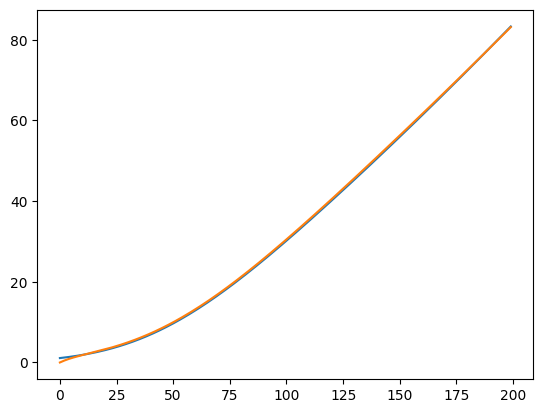

In [38]:
plt.plot(V_exact.iloc[-1])
plt.plot(V_numerical.iloc[-1])

#### change of methods

In [17]:
method_1 = pd.read_csv('weight_matrix_U_2.csv').iloc[:, 1:]
method_2 = pd.read_csv('weight_matrix_U.csv').iloc[:, 1:]